# Learn a Reward Function using Maximum Conditional Entropy Inverse Reinforcement Learning

Here, we're going to take a tabular environment with a pre-defined reward function, Cliffworld, and solve for the optimal policy. We then generate demonstrations from this policy, and use them to learn an approximation to the true reward function with MCE IRL. Since we know the ground truth reward function in this example, we can directly compare it to the learned reward.

Cliffworld is a POMDP, and its "observations" consist of the observations proper and the hidden environment state. We use `DictExtractWrapper` to extract only the hidden states from the environment, turning it into a fully observable MDP to make computing the optimal policy easy.

In [2]:
from functools import partial
from imitation.algorithms.mce_irl import (
    MCEIRL,
    mce_occupancy_measures,
    mce_partition_fh,
    TabularPolicy,
)

from imitation.data import rollout
from imitation.envs import resettable_env
from imitation.envs.examples.model_envs import CliffWorld
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.rewards import reward_nets


env_creator = partial(CliffWorld, height=4, horizon=8, width=7, use_xy_obs=True)
env_single = env_creator()

# This is just a vectorized environment because `generate_trajectories` expects one
state_venv = resettable_env.DictExtractWrapper(
    DummyVecEnv([env_creator] * 4), "state"
)

Then we derive an expert policy using Bellman backups. We analytically compute the occupancy measures, and also sample some expert trajectories.

In [18]:
import matplotlib.pyplot as plt

_, _, pi = mce_partition_fh(env_single)

_, om = mce_occupancy_measures(env_single, pi=pi)

expert = TabularPolicy(
    state_space=env_single.pomdp_state_space,
    action_space=env_single.action_space,
    pi=pi,
    rng=None,
)

expert_trajs = rollout.generate_trajectories(
    policy=expert,
    venv=state_venv,
    sample_until=rollout.make_min_timesteps(5000),
)

print("Expert stats: ", rollout.rollout_stats(expert_trajs))

Expert stats:  {'n_traj': 628, 'return_min': -24.0, 'return_mean': 6.146496815286624, 'return_std': 8.646132589013723, 'return_max': 14.0, 'len_min': 8, 'len_mean': 8.0, 'len_std': 0.0, 'len_max': 8}


### Training the reward function

The true reward here is not linear in the reduced feature space (i.e $(x,y)$ coordinates). Finding an appropriate linear reward is impossible, but an MLP should Just Work™.

In [61]:
import matplotlib.pyplot as plt
import torch as th
import numpy as np

def train_mce_irl(demos, hidden_sizes, lr = 0.01, **kwargs):
    reward_net = reward_nets.BasicRewardNet(
        env_single.pomdp_observation_space,
        env_single.action_space,
        hid_sizes=hidden_sizes,
        use_action=False,
        use_done=False,
        use_next_state=False,
    )

    mce_irl = MCEIRL(
        demos, env_single, reward_net,
        log_interval=250,
        optimizer_kwargs=dict(lr=lr)
    )
    occ_measure = mce_irl.train(**kwargs)

    imitation_trajs = rollout.generate_trajectories(
        policy=mce_irl.policy,
        venv=state_venv,
        sample_until=rollout.make_min_timesteps(5000),
    )
    print("Imitation stats: ", rollout.rollout_stats(imitation_trajs))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(occ_measure)
    plt.title("Occupancy for learned reward")
    plt.subplot(1, 2, 2)
    _, true_occ_measure = mce_occupancy_measures(env_single)
    print(f"{np.allclose(occ_measure, true_occ_measure)=}")
    env_single.draw_value_vec(true_occ_measure)
    plt.title("Occupancy for true reward")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(
        reward_net(th.as_tensor(env_single.observation_matrix), None, None, None).detach().numpy()
    )
    plt.title("Learned reward")
    plt.subplot(1, 2, 2)
    env_single.draw_value_vec(env_single.reward_matrix)
    plt.title("True reward")
    plt.show()

    return mce_irl

As you can see, a linear reward model cannot fit the data. Even though we're training the model on analytically computed occupancy measures for the optimal policy, the resulting reward and occupancy frequencies diverge sharply.

--------------------------
| grad_norm   | 4.45     |
| iteration   | 0        |
| linf_delta  | 2.21     |
| weight_norm | 0.86     |
--------------------------
--------------------------
| grad_norm   | 1.52     |
| iteration   | 250      |
| linf_delta  | 1.8      |
| weight_norm | 1.51     |
--------------------------
--------------------------
| grad_norm   | 0.62     |
| iteration   | 500      |
| linf_delta  | 1.58     |
| weight_norm | 2.4      |
--------------------------
--------------------------
| grad_norm   | 0.378    |
| iteration   | 750      |
| linf_delta  | 1.49     |
| weight_norm | 3        |
--------------------------
Imitation stats:  {'n_traj': 628, 'return_min': -71.0, 'return_mean': -23.10987261146497, 'return_std': 14.727969556083373, 'return_max': 14.0, 'len_min': 8, 'len_mean': 8.0, 'len_std': 0.0, 'len_max': 8}
np.allclose(occ_measure, true_occ_measure)=False


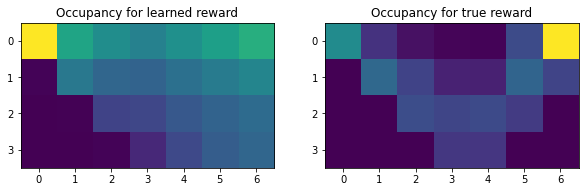

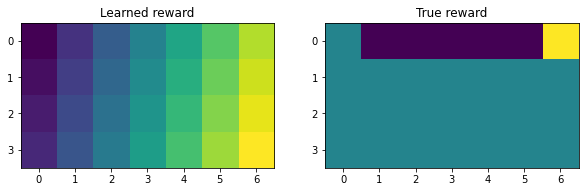

In [62]:
train_mce_irl(om, hidden_sizes=[])

Now, let's try using a very simple nonlinear reward model: an MLP with a single hidden layer. We first, we train it on the analytically computed occupancy measures. This should give a very precise result.

--------------------------
| grad_norm   | 16       |
| iteration   | 0        |
| linf_delta  | 2.03     |
| weight_norm | 11.6     |
--------------------------
--------------------------
| grad_norm   | 0.0708   |
| iteration   | 250      |
| linf_delta  | 0.044    |
| weight_norm | 18.8     |
--------------------------
--------------------------
| grad_norm   | 0.0686   |
| iteration   | 500      |
| linf_delta  | 0.016    |
| weight_norm | 20.8     |
--------------------------
--------------------------
| grad_norm   | 0.0159   |
| iteration   | 750      |
| linf_delta  | 0.00675  |
| weight_norm | 22.6     |
--------------------------
Imitation stats:  {'n_traj': 628, 'return_min': -31.0, 'return_mean': 5.923566878980892, 'return_std': 8.550555091508137, 'return_max': 14.0, 'len_min': 8, 'len_mean': 8.0, 'len_std': 0.0, 'len_max': 8}
np.allclose(occ_measure, true_occ_measure)=False


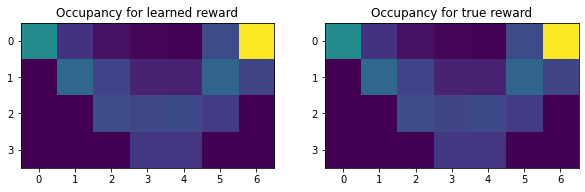

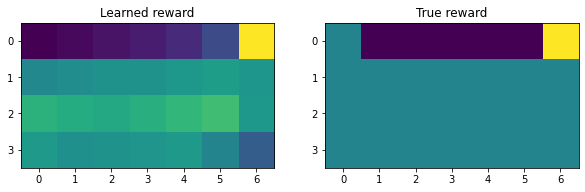

In [63]:
train_mce_irl(om, hidden_sizes=[256])

Then we train it on trajectories sampled from the expert. This gives a stochastic approximation to occupancy measure, so performance is a little worse. Using more expert trajectories should improve performance -- try it!

--------------------------
| grad_norm   | 18.4     |
| iteration   | 0        |
| linf_delta  | 2.57     |
| weight_norm | 11.7     |
--------------------------
--------------------------
| grad_norm   | 1.99     |
| iteration   | 100      |
| linf_delta  | 0.644    |
| weight_norm | 19.3     |
--------------------------
--------------------------
| grad_norm   | 3.63     |
| iteration   | 200      |
| linf_delta  | 0.557    |
| weight_norm | 36.5     |
--------------------------
--------------------------
| grad_norm   | 5.46     |
| iteration   | 300      |
| linf_delta  | 0.555    |
| weight_norm | 62.8     |
--------------------------
--------------------------
| grad_norm   | 11.3     |
| iteration   | 400      |
| linf_delta  | 0.563    |
| weight_norm | 92.9     |
--------------------------
--------------------------
| grad_norm   | 14       |
| iteration   | 500      |
| linf_delta  | 0.558    |
| weight_norm | 124      |
--------------------------
--------------------------
|

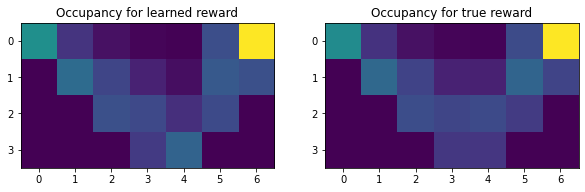

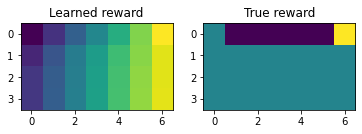

In [56]:
mce_irl_from_trajs = train_mce_irl(expert_trajs[0:10], hidden_sizes=[256])

While the learned reward function is quite different from the true reward function, it induces a virtually identical occupancy measure over the states. In particular, states below the top row get almost the same reward as top-row states. This is because in Cliff World, there is an upward-blowing wind which will push the agent toward the top row with probability 0.3 at every timestep.